In [94]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [95]:
import collections
import pandas as pd

from river import ensemble
from river import compose
from river import preprocessing
from river import tree

from source.health_risk_dataset import HealthRiskDataset

In [96]:
dataset = HealthRiskDataset()

Let's take a look at the first sample.

In [97]:
x, y = next(iter(dataset))
x

{'Age': 25,
 'SystolicBP': 130,
 'DiastolicBP': 80,
 'BS': 15.0,
 'BodyTemp': 98.0,
 'HeartRate': 86}

In [98]:
y

'high risk'

In [99]:
counts = collections.Counter(y for _, y in dataset)

for c, count in counts.items():
    print(f'{c}: {count} ({count / sum(counts.values()):.5%})')

high risk: 272 (26.82446%)
low risk: 406 (40.03945%)
mid risk: 336 (33.13609%)


In [100]:
# Creating a data frame
df = pd.read_csv("../datasets/Maternal-Health-Risk-Data-Set.csv")
df.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk


In [101]:
df.RiskLevel.unique()

array(['high risk', 'low risk', 'mid risk'], dtype=object)

In [102]:
def get_base_model():
    TARGET_COLUMN = 'RiskLevel'
    features = [feature for feature in df.columns if feature != TARGET_COLUMN]

    transform_pipeline = compose.Select(features[0])
    for feature in features[1:]:
        transform_pipeline += compose.Select(feature)
    transform_pipeline |= preprocessing.MinMaxScaler()

    return transform_pipeline | tree.HoeffdingTreeClassifier(grace_period=50, delta=0.01)

In [103]:
from river import tree
from source.stability_analyzer import StabilityAnalyzer

# base_model = linear_model.LogisticRegression()
base_model = get_base_model()
stability_analyzer = StabilityAnalyzer(base_model, metric_memory_length=1000)

In [104]:
dataset_limit = None
measure_every = 100
label_mapping = {
    'high risk': 1,
    'mid risk': 1,
    'low risk': 0,
}

for idx, (x, y_true) in enumerate(dataset):
    y_true = label_mapping[y_true]
    stability_analyzer.measure_metrics(x, y_true)

    if (idx + 1) % measure_every == 0:
        print(f'Index: {idx + 1}')
        stability_analyzer.print_metrics()

    # Shrink the dataset if needed
    if dataset_limit is not None and (idx + 1) == dataset_limit:
        break

y_true_lst: [1]
model_predictions: {0: [1], 1: [1], 2: [1], 3: [1], 4: [1], 5: [1], 6: [1], 7: [1], 8: [1], 9: [1]}


Accuracy: 1.0
Mean: 1.0
Std: 0.0
IQR: 0.0
Per sample accuracy: 1.0
Label stability: 1.0


y_true_lst: [1, 1]
model_predictions: {0: [1, 1], 1: [1, 1], 2: [1, 1], 3: [1, 1], 4: [1, 1], 5: [1, 1], 6: [1, 1], 7: [1, 1], 8: [1, 1], 9: [1, 1]}


Accuracy: 1.0
Mean: 1.0
Std: 0.0
IQR: 0.0
Per sample accuracy: 1.0
Label stability: 1.0


y_true_lst: [1, 1, 1]
model_predictions: {0: [1, 1, 1], 1: [1, 1, 1], 2: [1, 1, 1], 3: [1, 1, 1], 4: [1, 1, 1], 5: [1, 1, 1], 6: [1, 1, 1], 7: [1, 1, 1], 8: [1, 1, 1], 9: [1, 1, 1]}


Accuracy: 1.0
Mean: 1.0
Std: 0.0
IQR: 0.0
Per sample accuracy: 1.0
Label stability: 1.0


y_true_lst: [1, 1, 1, 0]
model_predictions: {0: [1, 1, 1, 1], 1: [1, 1, 1, 1], 2: [1, 1, 1, 1], 3: [1, 1, 1, 1], 4: [1, 1, 1, 1], 5: [1, 1, 1, 1], 6: [1, 1, 1, 1], 7: [1, 1, 1, 1], 8: [1, 1, 1, 1], 9: [1, 1, 1, 1]}


Accuracy: 0.75
Mean: 1.0
Std: 0.0
IQR: 0.0
Per sample accura

## Predict with HoeffdingTreeClassifier

In [92]:
from river import compose
from river import preprocessing

from source.utils.river_utils import evaluate_binary_model

# model = compose.Pipeline(
#     preprocessing.StandardScaler(),
#     get_base_model()
# )
model = get_base_model()
model

Pipeline (
  TransformerUnion (
    Select (
      Age
    ),
    Select (
      SystolicBP
    ),
    Select (
      DiastolicBP
    ),
    Select (
      BS
    ),
    Select (
      BodyTemp
    ),
    Select (
      HeartRate
    )
  ),
  MinMaxScaler (),
  HoeffdingTreeClassifier (
    grace_period=50
    max_depth=inf
    split_criterion="info_gain"
    delta=0.01
    tau=0.05
    leaf_prediction="nba"
    nb_threshold=0
    nominal_attributes=None
    splitter=GaussianSplitter (
      n_splits=10
    )
    binary_split=False
    max_size=100.
    memory_estimate_period=1000000
    stop_mem_management=False
    remove_poor_attrs=False
    merit_preprune=True
  )
)

Index: 50; Accuracy: 65.31%; CohenKappa: 41.17%; WeightedF1: 65.99%
Index: 100; Accuracy: 54.55%; CohenKappa: 28.55%; WeightedF1: 50.27%
Index: 150; Accuracy: 60.40%; CohenKappa: 40.81%; WeightedF1: 57.78%
Index: 200; Accuracy: 65.33%; CohenKappa: 45.96%; WeightedF1: 63.06%
Index: 250; Accuracy: 64.66%; CohenKappa: 44.49%; WeightedF1: 62.26%
Index: 300; Accuracy: 68.90%; CohenKappa: 49.38%; WeightedF1: 66.44%
Index: 350; Accuracy: 69.05%; CohenKappa: 48.79%; WeightedF1: 66.56%
Index: 400; Accuracy: 67.92%; CohenKappa: 47.38%; WeightedF1: 64.93%
Index: 450; Accuracy: 66.82%; CohenKappa: 46.60%; WeightedF1: 63.53%
Index: 500; Accuracy: 66.53%; CohenKappa: 46.02%; WeightedF1: 63.71%
Index: 550; Accuracy: 66.85%; CohenKappa: 46.09%; WeightedF1: 63.92%
Index: 600; Accuracy: 66.61%; CohenKappa: 45.60%; WeightedF1: 63.32%
Index: 650; Accuracy: 66.41%; CohenKappa: 45.62%; WeightedF1: 63.31%
Index: 700; Accuracy: 66.95%; CohenKappa: 46.22%; WeightedF1: 63.89%
Index: 750; Accuracy: 65.42%; Cohen

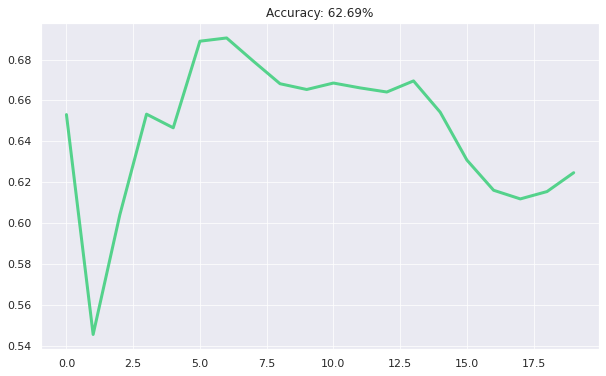

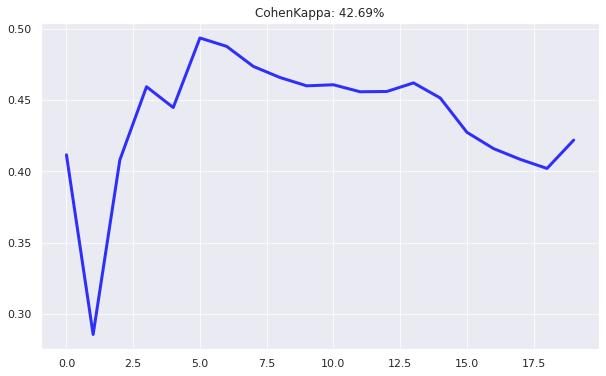

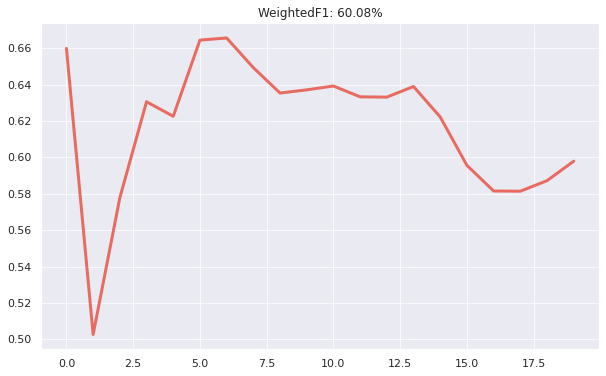

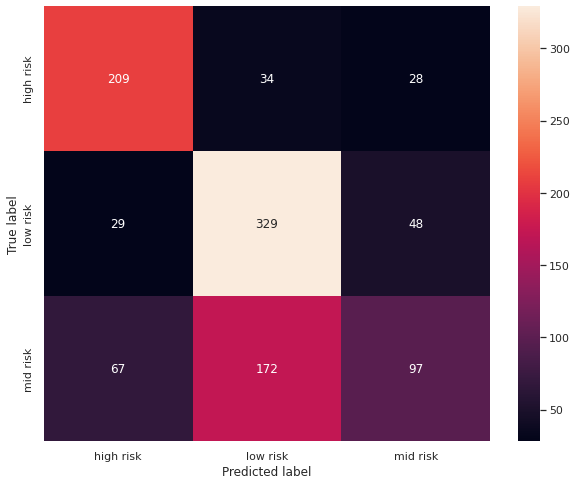

In [93]:
evaluate_binary_model(dataset, model, measure_every=50)